### Script 1
This script will select all the objects in a certain radius around the star and return a file (standards.txt) with the coordinates of these stars.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
%matplotlib inline

SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
hdu1 = fits.open('../data/coj1m003-fa19-20210112-0083-e91.fits.fz')
hdu2 = fits.open('../data/coj1m003-fa19-20210112-0084-e91.fits.fz')

imh = hdu1['SCI'].header
phot = hdu1['cat'].data
print (np.shape(np.array(phot['FLUX'])))
print (imh['Filter'])
print (hdu2['SCI'].header['Filter'])
print (np.shape(hdu2['cat'].data['FLUX']))

epoch = imh['MJD-OBS']
airmass = imh['AIRMASS']
print('Epoch = {:.5f} MJD'.format(epoch))
print('AIRMASS = {:.5f}'.format(airmass))

(801,)
gp
ip
(945,)
Epoch = 59226.45471 MJD
AIRMASS = 1.07476


801


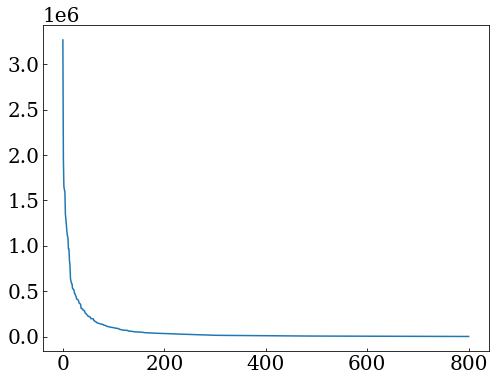

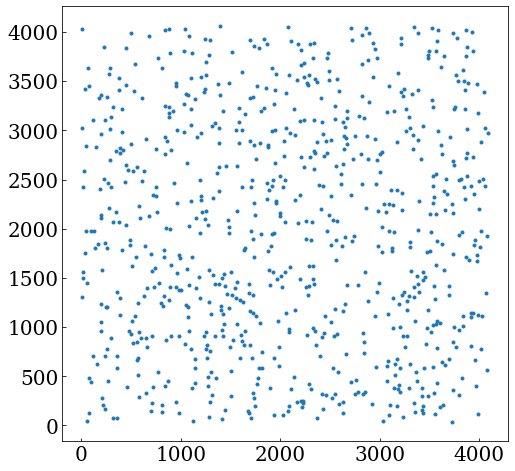

In [3]:
#print (hdu1['cat'].header)
#print (phot['x'])
#print (phot['flux'])
plt.plot(phot['flux'])
print(len(phot['x']))
plt.show()


plt.figure(figsize=(8,8))
plt.scatter(phot['x'],phot['y'], marker='.')
plt.show()

In [4]:
def find_min(xobj,yobj, xlist, ylist):
    'find the index of the star closest to position xobj, yobj'
    dr = (xlist-xobj)**2 + (ylist-yobj)**2
    # find min dr 
    ind = np.argmin(dr)
    print(np.sqrt(dr[ind]))
    return ind


def distance(xobj,yobj, xlist,ylist):
    'find the distance between target & objects round it, returns list with distances in pixels'
    d = (xobj-xlist)**2 + (yobj-ylist)**2
    return np.sqrt(d)

In [5]:
# read in the World Coordinate System (WCS) from the FITS file
# Parse the WCS keywords in the primary HDU
w = wcs.WCS(hdu1['SCI'].header)

# star coords in pix -  RA and Dec in decimal degrees
star_crd = w.wcs_world2pix([[90.0033, -31.0076]], 0)[0] #wcs_wordl2pix returns 2d array so [0] to make it 1d
print(star_crd)
# Coords of J0600: RA 90.0033 (06:00:00.792) Dec -31.0076 (-31:00:27.36)
# Epoch 2000 #Don't know what this means

# Hier een loopje plaatsen om de coordinaten van alle sterren naar pixel coordinaten te verplaatsen
# (of dat niet doen en in de pixel coordinaten werken en het later converteren (als je wilt))


[2053.56443333 2061.66291876]


Set OBSGEO-B to   -31.273025 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


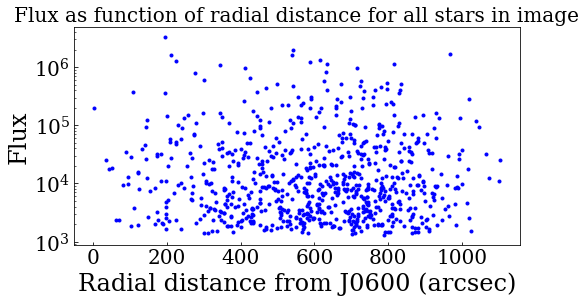

Nr of stars slected: 161


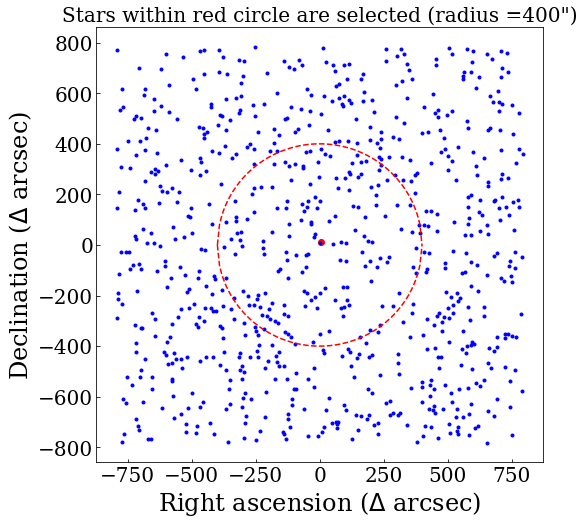

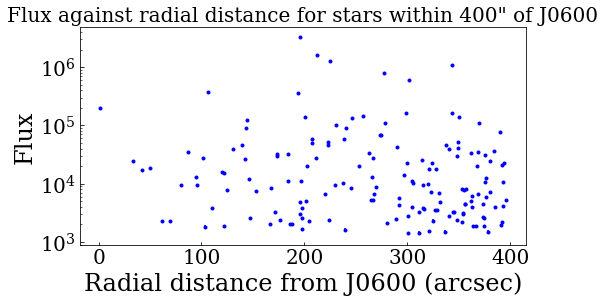

In [6]:
#calculate the distance of all stars to coordinates of J0600
dis = distance(star_crd[0], star_crd[1], phot['x'], phot['y'])

pix_asec = imh['PIXSCALE'] # Nominal pixel scale on sky [arcsec/pixel]
dis_asec = dis * pix_asec # convert distances in pixels to distances in arcseconds

# Make a plot of the flux as a funciton of the distance to J0600
# This has no use, other than me finding out if I can do it
plt.figure(figsize=(8,4))
plt.semilogy(dis_asec, phot['flux'], marker='.',linewidth=0, c='b')
plt.title("Flux as function of radial distance for all stars in image")
plt.xlabel("Radial distance from J0600 (arcsec)")
plt.ylabel("Flux")
plt.show()

# Select stars upto certain radial distance from J0600
radial_dis = 400 #arcsec
mask = dis_asec < radial_dis
print ("Nr of stars slected:",np.sum(mask))

# Here I make a nice plot where each dot is a star, and where the red dashed circle is the selection region
tmp = np.linspace(-radial_dis,radial_dis,100)
plt.figure(figsize=(8,8))
plt.scatter(star_crd[0]-2048,star_crd[1]-2048,c='r')
plt.scatter((phot['x']-2048)*pix_asec, (phot['y']-2048)*pix_asec, marker='.', c='b')
plt.plot(tmp, np.sqrt(radial_dis**2-tmp**2),  linestyle='dashed', c='r')
plt.plot(tmp, -np.sqrt(radial_dis**2-tmp**2),  linestyle='dashed', c='r')
plt.title("Stars within red circle are selected (radius ={:}\")".format(radial_dis))
plt.xlabel("Right ascension ($\Delta$ arcsec)")
plt.ylabel("Declination ($\Delta$ arcsec)")
#plt.axis(xmin=-805,xmax=805, ymin=-805, ymax=805)
plt.show()

# Finaly make a plot simmilar to the previous plot of flux against radial distance, but then for the selected stars
plt.figure(figsize=(8,4))
plt.yscale("log")
plt.errorbar(dis_asec[mask], phot['flux'][mask], yerr=phot['fluxerr'][mask], fmt='.', c='b')
plt.title("Flux against radial distance for stars within {:}\" of J0600".format(radial_dis))
plt.xlabel("Radial distance from J0600 (arcsec)")
plt.ylabel("Flux")
plt.show()


In [7]:
# Testig how to do the coordinate transformation from pixel->world
tmp = dis == np.min(dis)
target_pix = [phot['x'][tmp][0], phot['y'][tmp][0]]
print (target_pix)
test_crds = w.wcs_pix2world([target_pix],0)
print (test_crds)

[2052.4817773540663, 2064.5318380493304]
[[ 90.00316333 -31.00791009]]


In [8]:
# transforming the selected stars from the pixel coordinates to the RA & Dec coordinates
select_coords_pix = np.zeros((np.sum(mask),2))
select_coords_pix[:,0] = phot['x'][mask]
select_coords_pix[:,1] = phot['y'][mask]

select_coords = w.wcs_pix2world(select_coords_pix,0)
#print (select_coords)

# Sort this list according to the radial distance to target (0'th element is target (-1)'th element is furthest star)
sort_i = np.argsort(dis_asec[mask])
select_coords_sort = select_coords[sort_i]

In [9]:
# Write out the coordinates of the selected stars to a file
#filecontent = Table([select_coords_sort[:,0],select_coords_sort[:,1]], names=['RA','Dec'])
#ascii.write(filecontent, 'standards.txt', overwrite=True)